In [7]:
import os

outname = "database.fa"
with open(outname, 'wt') as outfile:
    for filename in os.listdir():
        dot = filename.find(".")
        if (filename[dot+1:] == 'fa') and filename != outname:
            species = filename[:dot].replace(" ", "_")
            with open(filename, 'rt') as infile:
                for line in infile:
                    if line[0] == '>':
                        line_parts = line.split('|')
                        if len(line_parts) > 1:
                            outfile.write(f">{line_parts[1]}_{species}\n")
                        else:
                            outfile.write(f">{species}\n")
                    else:
                        outfile.write(line)
            print(f"Finished processing {filename}")

print("All .fa files merged successfully into", outname)


Finished processing human.fa
Finished processing mouse.fa
All .fa files merged successfully into database.fa


In [10]:
import os
import subprocess
import pandas as pd
from Bio import SeqIO

# Set up BLAST environment path
blast_path = r"D:\NCBI\blast-2.16.0+\bin"  # Modify this to your BLAST installation path
os.environ["PATH"] += os.pathsep + blast_path

# File paths
human_sequences_file = "human.fa"  # File containing human sequences
mouse_db_file = "merged_db"  # The name of the newly created BLAST database
output_file = "blast_results.csv"  # Output file

# List to store BLAST results
blast_results = []

# Parse human sequences and run BLAST
for record in SeqIO.parse(human_sequences_file, "fasta"):
    # Write query sequence to a temporary file
    query_file = "temp_query.fa"
    with open(query_file, "w") as temp_f:
        SeqIO.write(record, temp_f, "fasta")

    # Run BLAST search with adjusted parameters
    blast_command = [
        "blastp",  # Use BLASTp for protein alignment
        "-query", query_file,
        "-db", mouse_db_file,
        "-outfmt", "6 qseqid sseqid evalue bitscore",
        "-max_target_seqs", "1",  # Return only the best match
        "-evalue", "10"  # Set a reasonable E-value threshold to find more matches
    ]
    result = subprocess.run(blast_command, capture_output=True, text=True)
    
    # Store BLAST result
    if result.returncode == 0:
        if result.stdout.strip():  # Ensure that there is output to process
            for line in result.stdout.strip().split("\n"):
                qseqid, sseqid, evalue, bitscore = line.split("\t")
                blast_results.append([qseqid, sseqid, float(evalue), float(bitscore)])
        else:
            print(f"No results found for {record.id}")
    else:
        print(f"Error running BLAST for {record.id}: {result.stderr}")

# Create a DataFrame and save results to CSV
columns = ["Query ID", "Subject ID", "E-value", "Bit Score"]
df = pd.DataFrame(blast_results, columns=columns)

# Save DataFrame to CSV file
if not df.empty:
    df.to_csv(output_file, index=False)
    print("BLAST search completed. Results saved to", output_file)
else:
    print("No BLAST results to save.")

# Clean up temporary query file
if os.path.exists(query_file):
    os.remove(query_file)


BLAST search completed. Results saved to blast_results.csv


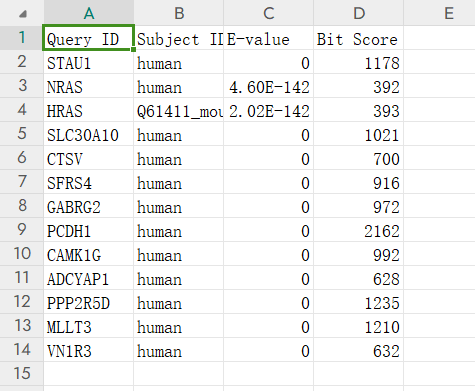

(i) The chosen BLAST program is blastp. This is because the sequences in human.fa are protein sequences, and blastp is specifically designed for protein-protein sequence comparisons. blastp allows us to identify homologous proteins by comparing the query protein sequences against a protein database. Using blastp ensures that the comparison takes into account the amino acid similarities, making it suitable for identifying functional relationships and evolutionary conservation.

(ii) The default substitution matrix used in blastp is BLOSUM62. BLOSUM62 is commonly used for protein alignments because it is effective for identifying homologous proteins with moderate evolutionary divergence. It assigns scores based on the likelihood of substituting one amino acid for another during evolution, with higher scores indicating more likely substitutions. Using BLOSUM62 is appropriate for our analysis, as it provides a good balance between sensitivity and specificity for finding evolutionary relationships among proteins.

(iii) E-value: An E-value of 10 was chosen to ensure that all significant matches are retrieved, including those with moderate similarity. A lower E-value (e.g., 1e-5) could be used to filter out weaker matches, retaining only the most significant hits.
Max Target Sequences (-max_target_seqs): The value was set to 1 to return only the best match for each query sequence. This helps simplify the analysis by focusing on the most relevant homolog. If more potential matches are needed, this value can be increased (e.g., to 5 or 10).